In [7]:
#testing if path is correct
import os

database_path = "hawaii.sqlite"
absolute_path = os.path.abspath(database_path)

print(f"Absolute path: {absolute_path}")

Absolute path: c:\Users\ilian\OneDrive\Desktop\BC Work\sqlalchemy-challenge\Starter_Code\hawaii.sqlite


In [43]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('ggplot')
style.use('fivethirtyeight')

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
# create engine to hawaii.sqlite
engine=create_engine('sqlite:///Resources/hawaii.sqlite')

Base = automap_base()


In [27]:
# reflect an existing database into a new model

# reflect the tables
Base.prepare(autoload_with=engine)



C:\Users\ilian\AppData\Local\Temp\ipykernel_18508\507112866.py:4: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine)
C:\Users\ilian\AppData\Local\Temp\ipykernel_18508\507112866.py:4: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine)


In [30]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [71]:
# Find the most recent date in the data set.
recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date = dt.date.fromisoformat(recent_date_str)
recent_date

datetime.date(2017, 8, 23)

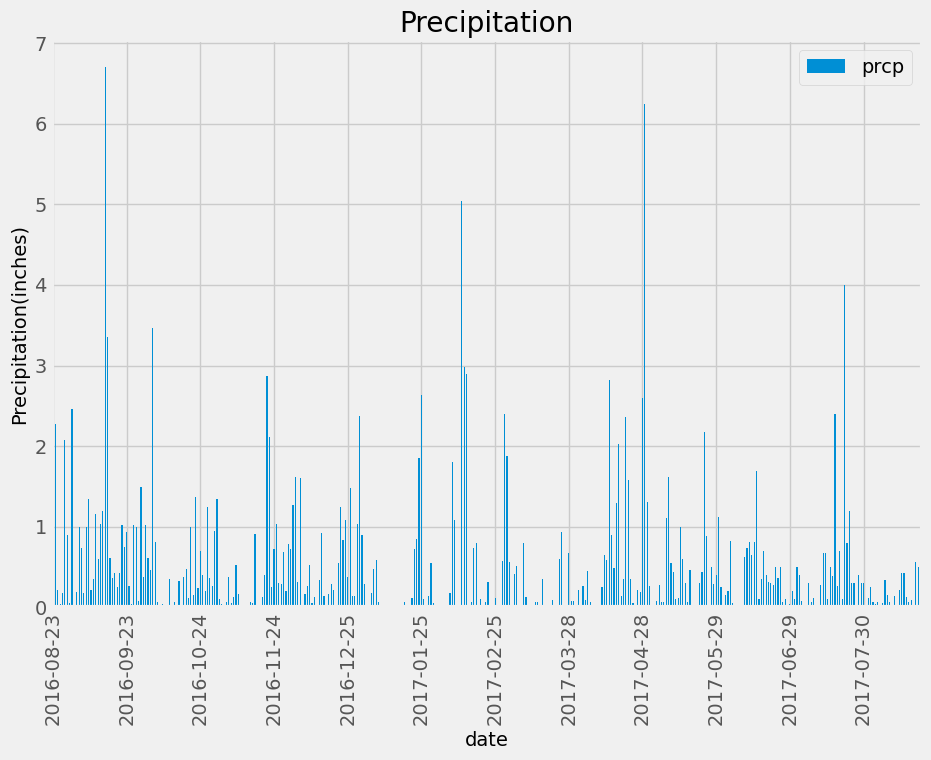

In [72]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
Prev_Last_date = dt.date(recent_date.year-1,recent_date.month,recent_date.day)
Prev_Last_date

# Perform a query to retrieve the data and precipitation scores
ann_prcp = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(ann_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
plt.xticks(rotation = 90)
plt.title("Precipitation")
plt.ylabel("Precipitation(inches)")
plt.locator_params(axis='x',nbins=12)
plt.show()

In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Sort the dataframe by date
ann_prcp=(session.query(Measurement.date, Measurement.prcp)
                        .filter(Measurement.date > Prev_Last_date)
                        .all())
ann_prcp_df=pd.DataFrame(ann_prcp, columns=['date', 'prcp'])

ann_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [73]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()

total_stations

9

In [74]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
qry_most_active_stations = session.query(
        Measurement.station,
        func.count(Measurement.station)
    ).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

most_active_stations = qry_most_active_stations.all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = qry_most_active_stations.first()[0]
most_active_station_id

temp_summ = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).\
    filter(Measurement.station == most_active_station_id).all()
temp_summ

[(54.0, 85.0, 71.66378066378067)]

<Axes: xlabel='Temperature (F)', ylabel='Frequency'>

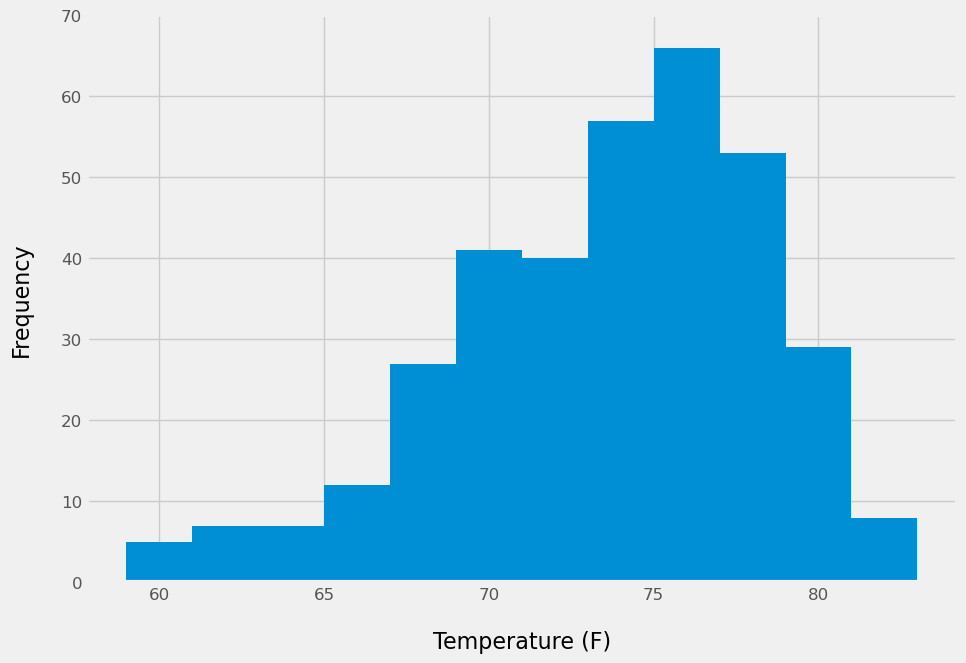

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

ann_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(
        Measurement.date >= func.strftime("%Y-%m-%d",Prev_Last_date), 
        Measurement.station == most_active_station_id
    ).\
    order_by(Measurement.date).all()

df = pd.DataFrame(ann_tobs, columns=['date', 'tobs'])

hist = df["tobs"].hist(bins=12)
plt.xlabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='black',labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)

hist

# Close Session

In [16]:
# Close Session
session.close()